In [4]:
from tensorflow.keras.models import load_model
import tensorflow as tf
model = load_model('../1_inital_model_liczone_odrazu_rr/model.h5')
model.load_weights('../1_inital_model_liczone_odrazu_rr/model.weights.h5')

import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import os

root = "../own_data_train"
# Lista plików (zakładając, że masz już listę plików, np. z os.listdir)
file_list = os.listdir(root)  # Zastąp 'ścieżka_do_twojego_folderu' odpowiednią ścieżką

# Inicjalizacja listy do przechowywania danych
data = []

# Iteracja po liście plików
for filename in file_list:
    # Wydobywanie liczby całkowitej z nazwy pliku przy użyciu wyrażenia regularnego
    match = re.search(r'\d+', filename)  # Zakładając, że liczba całkowita składa się z co najmniej jednej cyfry
    if match:
        integer = int(match.group())
        data.append({'cycles': integer, 'filename': filename[:-4]})

# Konwersja listy do DataFrame
df = pd.DataFrame(data, columns=['cycles', 'filename'])
# print(type(df["cycles"][0]))

# Parametry zduplikowania
duplication_factor = 1  # Ilość zduplikowania danych

# Wczytanie danych z CSV
audio_data = root + "/"
# df = pd.read_csv('cycles_count_own_data.csv', names=['Start', 'filename'], header=0)
def add_noise(data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data, x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

def mfcc_feature_extraction_rr(dir_):
    X_ = []
    y_ = []
    data = df
    features = 50
    for soundDir in os.listdir(dir_):
        if soundDir[-3:] == 'wav':
            label = list(data[data['filename'] == (soundDir[:-4])]['cycles'])[0]
            audio_length = librosa.get_duration(filename=f'{root}/{soundDir}')
            label = label / (audio_length / 60)            
            data_x, sampling_rate = librosa.load(dir_ + soundDir, res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
            # Dodajemy cechy i etykiety
            X_.append(mfccs)
            y_.append(label)
            
            data_shift = shift(data_x,1600)
            mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_shift)
            y_.append(label)
            
            data_noise = add_noise(data_x,0.005)
            mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_noise)
            y_.append(label)
    
    # Zduplikowanie danych
    X_data = np.tile(np.array(X_), (duplication_factor, 1))
    y_data = np.tile(np.array(y_), duplication_factor)
    
    return X_data, y_data

# Wywołanie funkcji ekstrakcji cech
res_data, res_y = mfcc_feature_extraction_rr(audio_data)


# Podział danych na zbiory treningowe, walidacyjne i testowe
x_train, x_val, y_train, y_val = train_test_split(res_data, res_y, test_size=0.175, random_state=10)

# Wyświetlenie rozmiarów zbiorów danych
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)

# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    x_train_lstm, y_train, batch_size=16, epochs=1000, validation_data=(x_val_lstm, y_val),
  )

# Zapisz zaktualizowany model
model.save("model_1500.h5")
model.save_weights('model_1500.weights.h5')

import pickle
with open('model_1500trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

C:\Users\u144572\AppData\Local\Temp\ipykernel_43856\3804963141.py:64: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_length = librosa.get_duration(filename=f'{root}/{soundDir}')


(94, 50) (20, 50)
(94,) (20,)
Epoch 1/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 74.0277 - mae: 6.8398 - val_loss: 23.1118 - val_mae: 3.6241
Epoch 2/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 32.1756 - mae: 4.2781 - val_loss: 21.0609 - val_mae: 3.6038
Epoch 3/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 43.6137 - mae: 5.2622 - val_loss: 22.2836 - val_mae: 3.5498
Epoch 4/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 34.7745 - mae: 4.6948 - val_loss: 19.7457 - val_mae: 3.4368
Epoch 5/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 21.9758 - mae: 3.6189 - val_loss: 19.1359 - val_mae: 3.4564
Epoch 6/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 40.9550 - mae: 4.8588 - val_loss: 21.5756 - val_mae: 3.7227
Epoch 7/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 31.9053 - mae: 4.2394 - val_loss: 21.2863 - val_mae: 3.8418
Epoch 8/1500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 39.3347 - mae: 4.4059 - val_loss: 22.9218 - val_mae: 3.9401
Epoch 9/15

C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


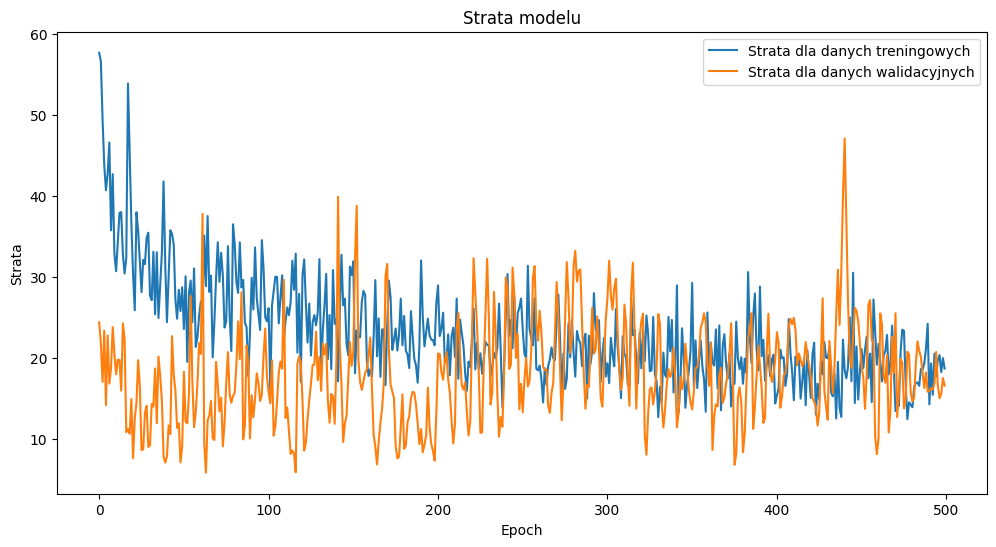

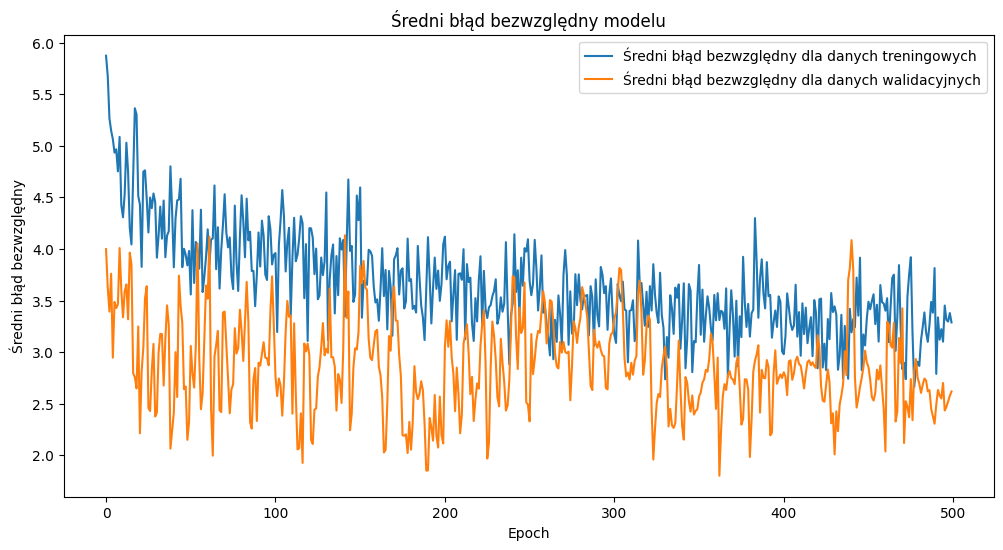

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from keras.models import load_model
# Assuming `history` is the History object returned by model.fit()
# and `x_test_lstm`, `y_test` are the test datasets
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)
model = load_model("model.h5")
model.load_weights('model.weights.h5')

import os
if not os.path.isdir("plots_training"):
    os.makedirs('plots_training')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Strata dla danych treningowych')
plt.plot(history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.savefig("plots_training/Strata dla danych treningowych")
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.savefig("plots_training/Średni błąd bezwzględny dla danych treningowych")
plt.show()

